# Executive Master Statistique & Big Data
# Optimization Assignment - Gradient Descent
July 2018

Elodie Zanella  
Oussama Berguiga  

**Data: Pima Indians Diabetes Database**  
**Objective: Predict whether a patient has diabetes based on diagnostic measurements**

*Originally from Mexico, the Pima Indians of the United States settled in the Sonoran Desert (Arizona) about thirty thousand years ago. Remained genetically isolated from neighboring populations for millennia and practicing subsistence agriculture, they were caught by the affluent society (sedentary, overconsumption ...). They hold a world record, that of the prevalence (percentage of individuals affected, in all cases) of non-insulin-dependent diabetes mellitus (NIDDM) or type 2 diabetes. For the past 30 years, NIDDM has been steadily increasing worldwide, but nowhere else is the epidemic as devastating as it is among the pimas.*   

In that problem all the patients are women older than 21 years old with Pima Indian origins.
The dataset columns are the following :
- glu :  plasma glucose concentration in an oral glucose tolerance test
- npreg : number of pregnancies
- bp : diastolic blood pressure (mm Hg). :  
- skin : triceps skin fold thickness (mm)
- bmi : body mass index (weight in kg/(height in m)\^2)
- ped : diabetes pedigree function
- age : age in years
- type : Yes or No, for diabetic according to WHO criteria

## Data loading & exploration 

In [16]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import itertools
from itertools import cycle

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

%matplotlib inline

In [17]:
import os
path="/Users/Elodie/Desktop/Statistique & Big Data/Module 3/Optimisation"
os.chdir(path)

In [18]:
# preliminary functions definitions
def find(x): return np.nonzero(x)[0]
def MakeCol(y): return y.reshape(-1,1)

In [19]:
data_train=pd.read_csv('Pima.tr.csv',index_col=0)
data_test=pd.read_csv('Pima.te.csv',index_col=0)
data_global=pd.concat([data_train,data_test],axis=0)

In [20]:
data_train.head()

,npreg,glu,bp,skin,bmi,ped,age,type
1,5,86,68,28,30.2,0.364,24,No
2,7,195,70,33,25.1,0.163,55,Yes
3,5,77,82,41,35.8,0.156,35,No
4,0,165,76,43,47.9,0.259,26,No
5,0,107,60,25,26.4,0.133,23,No


In [21]:
data_train['type']=data_train.apply(lambda row: -1 if row['type']=='No' else 1, axis=1)
data_train.head()

,npreg,glu,bp,skin,bmi,ped,age,type
1,5,86,68,28,30.2,0.364,24,-1
2,7,195,70,33,25.1,0.163,55,1
3,5,77,82,41,35.8,0.156,35,-1
4,0,165,76,43,47.9,0.259,26,-1
5,0,107,60,25,26.4,0.133,23,-1


In [22]:
n = data_train.shape[0] # number of sample
p = data_train.drop(['type'],axis=1).shape[1] # dimensionality
print(n,p)

200 7


In [23]:
data_train.dtypes

npreg      int64
glu        int64
bp         int64
skin       int64
bmi      float64
ped      float64
age        int64
type       int64
dtype: object

In [24]:
data_train.isnull().sum().sum()/(data_train.shape[0]*data_train.shape[1])

0.0

No missing data.

In [25]:
data_train.describe().round(2)

,npreg,glu,bp,skin,bmi,ped,age,type
count,200.00,200.00,200.00,200.00,200.00,200.00,200.00,200.00
mean,3.57,123.97,71.26,29.22,32.31,0.46,32.11,-0.32
std,3.37,31.67,11.48,11.72,6.13,0.31,10.98,0.95
min,0.00,56.00,38.00,7.00,18.20,0.08,21.00,-1.00
25%,1.00,100.00,64.00,20.75,27.58,0.25,23.00,-1.00
50%,2.00,120.50,70.00,29.00,32.80,0.37,28.00,-1.00
75%,6.00,144.00,78.00,36.00,36.50,0.62,39.25,1.00
max,14.00,199.00,110.00,99.00,47.90,2.29,63.00,1.00


Data standardization

In [26]:
X_train=data_train.drop(['type'],axis='columns').values
scaler = StandardScaler().fit(X_train)

X_train=scaler.transform(X_train)
y_train=data_train.type.values
y_train=MakeCol(y_train)

In [27]:
print(X_train.mean(axis=0))
print(X_train.std(axis=0))

[ 2.66453526e-17  3.55271368e-17 -4.26325641e-16  3.55271368e-17
 -3.90798505e-16 -1.29896094e-16  7.10542736e-17]
[1. 1. 1. 1. 1. 1. 1.]


In [28]:
y_global=data_global.type.values
y_global=MakeCol(y_global)

unique, counts = np.unique(y_global, return_counts=True)
M=np.asarray((unique, counts)).T
print (M)
print(round(M[0][1]/(M[0][1]+M[1][1]),3))

[['No' 355]
 ['Yes' 177]]
0.667


532 observations in the global training+test data set; among them, 177 (33,3%) with Diabetes.  
Major class = No Diabetes, 66,7% of the sample.  
As a result, if one always predicts the major class, the error will be 0.333 (**accuracy = 0.667**). This gives us a first idea to assess error/accuracy

Data vizualization in reduced dimension (ACP)

In [29]:
pca = PCA(n_components=p,)
array = pca.fit_transform(X_train)

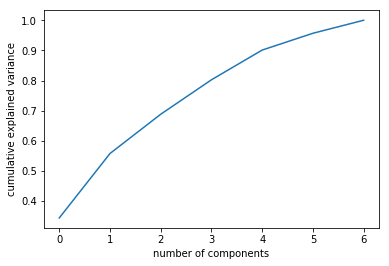

In [30]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [31]:
print(round(pca.explained_variance_ratio_[0]+pca.explained_variance_ratio_[1],3))

0.558


The first 2 principal components explain 55,8% of the total variance. Let's vizualize data in 2 dimensions.

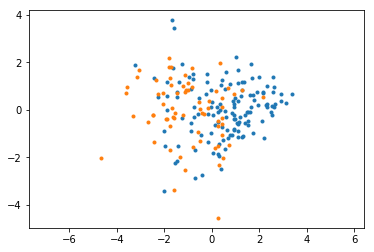

In [32]:
U, s, V = np.linalg.svd(X_train)
Xr = X_train.dot(V.transpose())

I = find(y_train==-1)
J = find(y_train==+1)

plt.plot(Xr[I[0:n],0], Xr[I[0:n],1], '.')
plt.plot(Xr[J[0:n],0], Xr[J[0:n],1], '.')
plt.axis('equal');

In [33]:
print(round(pca.explained_variance_ratio_[0]+pca.explained_variance_ratio_[1]+pca.explained_variance_ratio_[2],3))

0.688


The first 3 principal components explain 68,8% of the total variance. Let's vizualize data in 3 dimensions.

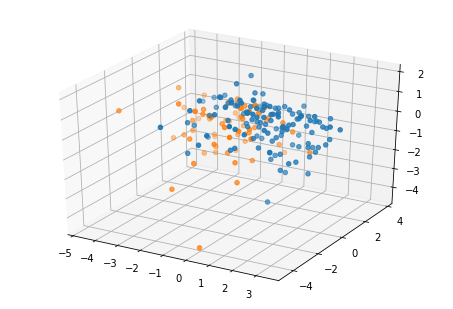

In [34]:
fig = plt.figure()
ax = Axes3D(fig)
plt.clf
ax.scatter(Xr[I[0:n],0], Xr[I[0:n],1], Xr[I[0:n],2], '.')
ax.scatter(Xr[J[0:n],0], Xr[J[0:n],1], Xr[J[0:n],2], '.')
plt.axis('tight');

# Data Modeling

## Logistic Regression with Gradient Descent 

Modelization of the probability of belonging to the two classes for sample $x_i$ as 

$$ h(x_i)=(\theta(x_i),1-\theta(x_i))$$  where   $$\theta(s) = \frac{e^{s}}{1+e^s} = (1+e^{-s})^{-1}  
$$


Re-writting the energy to minimize

$$ E(w) = L(X w,y) = L(s,y)= \frac{1}{n}  \sum_i L(s_i,y_i), 
$$

its gradient reads

$$ \nabla E(w) = X^\top \nabla L(X w,y)
      =
      \nabla L(s,y) = \frac{y}{n} \odot \theta(-y \odot s),   
$$

where $\odot$ is the pointwise multiplication operator, i.e. * in
Python.


First we define the energies:

In [35]:
def L(s,y):  return 1/n * sum( np.log( 1 + np.exp(-s*y) ) )
def E(w,X,y): return L(X.dot(w),y);
def theta(v): return 1 / (1+np.exp(-v))

Then we define their gradient:

In [36]:
def nablaL(s,r): return - 1/n * r * theta(-s * r)
def nablaE(w,X,y): return X.transpose().dot( nablaL(X.dot(w),y))

Important: in order to improve performance, it is important (especially
in low dimension $p$) to add a constant bias term $w_{p+1} \in \mathbb{R}$, and replace $<{x_i},{w}>$
by $ <{x_i},{w}> + w_{p+1} $.  This is equivalently achieved by
adding an extra $(p+1)^{\text{th}}$ dimension equal to 1 to each
$x_i$, which we do using a convenient macro.

In [37]:
def AddBias(X): return np.hstack((X,np.ones((np.size(X,0),1))))

Perform one step of gradient descent reads
$$ w_{\ell+1} = w_\ell - \tau_\ell \nabla E(w_\ell). $$

In the convex case, if the function to minimize is of class $C^2$, which is the case here, in order to ensure convergence, the step size $\tau_l$ should satisfy
$$ 0 < \tau_l < \frac{2}{ \sup_x {||HE(x)||} } $$
where $HE(x) \in \mathbb{R}^{d \times d}$ is the Hessian of $E$ at $x$ and ||${\cdot}$|| is the spectral operator norm (largest eigenvalue). 

Let's try several values for the step size (grid test):

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10


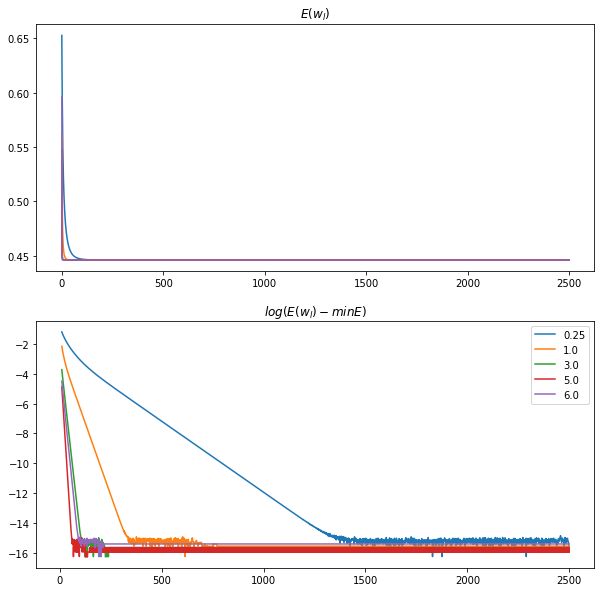

In [38]:
tau_list = np.array([0.25, 1, 3, 5, 6])
plt.figure(figsize=(10,10))

for itau in np.arange(0,tau_list.size):
    tau = tau_list[itau]
    niter = 5000
    Elist = np.zeros([niter,1])
    w = np.zeros((p+1,1)) # initialization
    for i in np.arange(0,niter):
        w = w - tau * nablaE(w,AddBias(X_train),y_train)
        Elist[i] = E(w,AddBias(X_train),y_train)
        #print(E(w,AddBias(X_train),y_train))
    ndisp = int(niter/2)

    ## display ##
    plt.clf
    plt.subplot(2,1,1)
    plt.plot(np.arange(0,ndisp), Elist[0:ndisp])
    plt.axis('tight')
    plt.title('$E(w_l)$')
    plt.subplot(2,1,2);
    plt.plot(np.arange(10,ndisp), np.log10(Elist[10:ndisp]-np.min(Elist))  )
    plt.axis('tight')
    plt.title('$log(E(w_l) - min E)$')
    plt.legend(tau_list,loc='upper right')

$\tau_l$ = 5 seems to be near the optimal step size.

In [39]:
print(w) # Coordinates of the global minimum, ie solution of the optimization problem

[[ 0.3464736 ]
 [ 1.01450486]
 [-0.0545925 ]
 [-0.02241548]
 [ 0.51134911]
 [ 0.55787535]
 [ 0.45087576]
 [-0.95583051]]


### Prediction on test dataset based on optimal w & model evaluation

In [40]:
data_test['type']=data_test.apply(lambda row: -1 if row['type']=='No' else 1, axis=1)
data_test.head()

,npreg,glu,bp,skin,bmi,ped,age,type
1,6,148,72,35,33.6,0.627,50,1
2,1,85,66,29,26.6,0.351,31,-1
3,1,89,66,23,28.1,0.167,21,-1
4,3,78,50,32,31.0,0.248,26,1
5,2,197,70,45,30.5,0.158,53,1


In [41]:
X_test=data_test.drop(['type'],axis='columns').values

X_test=scaler.transform(X_test)
y_test=data_test.type.values
y_test=MakeCol(y_test)

In [42]:
print(X_test.mean(axis=0))
print(X_test.std(axis=0))

[-0.02533182 -0.14913797  0.0343742  -0.00447613  0.15204894  0.22066331
 -0.07250069]
[0.97642626 0.96413853 1.11607391 0.83225064 1.1892204  1.18363022
 0.97006121]


In [43]:
Theta=theta(AddBias(X_test).dot(w))

In [44]:
def return_class(x):    
    if x<0.5:
        return (-1)
    else:
        return (1)

In [45]:
y_test_pred=np.apply_along_axis(return_class,1,Theta)
y_test_pred=np.array(y_test_pred).reshape(-1,1)

In [46]:
#y_pred

In [47]:
accuracy_score(y_test, y_test_pred)

0.8012048192771084

In [48]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Purples):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.9  0.1 ]
 [0.39 0.61]]


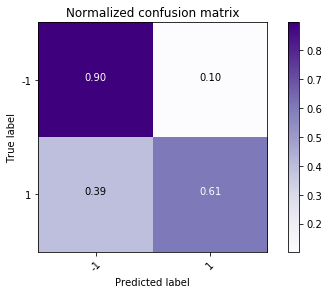

In [49]:
class_names=[-1,1]
cnf_matrix = confusion_matrix(y_test, y_test_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')

We manage to correctly predict with an accuracy of **80.1%**, which is rather satisfaying as major class account for 66,7% of the sample.   
Nonetheless, not surprisingly, performance is better on major class as shown in above confusion matrix (we predict correctly in 90% of cases for class -1).  
We can test other models.

# Kernel Logistic Classification


Logistic classification tries to separate the classes using
a linear separating hyperplane  {${x},{<{w},{x}>=0}$}. 


In order to generate a non-linear descision boundary, one can replace the
parametric linear model by a non-linear [non-parametric](https://en.wikipedia.org/wiki/Nonparametric_statistics) model, thanks to
kernelization. It is non-parametric in the sense that the number of
parameter grows with the number $n$ of sample (while for the basic
method, the number of parameter is $p$. This allows in particular to
generate decision boundary of arbitrary complexity.


The downside is that the numerical complexity of the method grows
(at least) quadratically with $n$.


The good news however is that thanks to the theory of
 [reproducing kernel Hilbert spaces](https://en.wikipedia.org/wiki/Reproducing_kernel_Hilbert_space)
(RKHS), one can still compute this non-linear decision
function using (almost) the same numerical algorithm.


Given a kernel $ \kappa(x,z) \in \mathbb{R} $ defined for $(x,z) \in \mathbb{R}^p$,
the kernelized method replace the linear decision functional $f(x) =
<{x},{w} >$  by a sum of kernel centered on the samples
$$ f_h(x) = \sum_{i=1}^p h_i k(x_i,x) $$
where $h \in \mathbb{R}^n$ is the unknown vector of weight to find.


When using the linear kernel $\kappa(x,y)=<{x},{y}>$, one retrieves
the previously studied linear method.


Macro to compute pairwise squared Euclidean distance matrix.

The gaussian kernel is the most well known and used kernel
$$ \kappa(x,y) = e^{-\frac{||{x-y}||^2}{2\sigma^2}} . $$
The bandwidth parameter $\sigma>0$ is crucial and controls the locality of
the model. It is typically tuned through cross validation.

In [50]:
def distmat1(X,Z):
    D = np.zeros((X.shape[0],Z.shape[0]))
    for i in np.arange(0,X.shape[0]):
        for j in np.arange(0,Z.shape[0]):
            D[i,j] = np.linalg.norm( X[i,:]-Z[j,:] );
    return D

In [51]:
from scipy import spatial
def distmat(X,Z): return spatial.distance.cdist(X,Z)**2

In [52]:
def kappa(X,Z,sigma): return np.exp( -distmat(X,Z)/(2*sigma**2) )

In [53]:
def F(h,K,y): return L(K.dot(h),y)
def nablaF(h,K,y): return K.transpose().dot( nablaL(K.dot(h),y) )

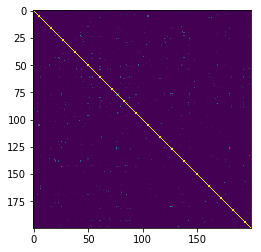

In [54]:
sigma = 0.5;
K = kappa(AddBias(X_train),AddBias(X_train),sigma)
plt.imshow(K);

(-3999.9500000000003, 83998.95, -0.029670788823302943, 0.7264132636476944)

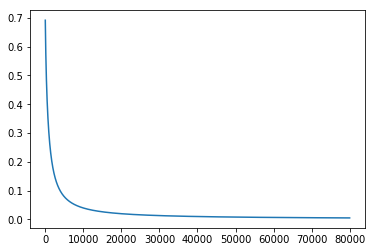

In [55]:
niter = 80000
Flist = np.zeros([niter,1])
tau = .5
h = np.zeros([n,1])
for i in np.arange(0,niter):
    h = h - tau * nablaF(h, K, y_train)
    Flist[i] = F(h, K, y_train)
plt.clf
plt.plot(np.arange(0,niter), Flist)
plt.axis('tight')

In [56]:
K1 = kappa(AddBias(X_test),AddBias(X_train),sigma)
Theta = theta( K1.dot(h) )

In [57]:
Theta

array([[0.82],
       [0.29],
       [0.01],
       [0.24],
       [0.5 ],
       [0.51],
       [0.49],
       [0.5 ],
       [0.52],
       [0.57],
       [0.01],
       [0.61],
       [0.1 ],
       [0.63],
       [0.49],
       [0.57],
       [0.1 ],
       [0.5 ],
       [0.41],
       [0.5 ],
       [0.5 ],
       [0.5 ],
       [0.13],
       [0.32],
       [0.02],
       [0.07],
       [0.54],
       [0.06],
       [0.22],
       [0.31],
       [0.5 ],
       [0.  ],
       [0.62],
       [0.22],
       [0.45],
       [0.17],
       [0.  ],
       [0.44],
       [0.5 ],
       [0.04],
       [0.49],
       [0.01],
       [0.5 ],
       [0.48],
       [0.5 ],
       [0.01],
       [0.38],
       [0.5 ],
       [0.12],
       [0.06],
       [0.74],
       [0.23],
       [0.55],
       [0.01],
       [0.5 ],
       [0.02],
       [0.5 ],
       [0.51],
       [0.11],
       [0.52],
       [0.63],
       [0.01],
       [0.06],
       [0.32],
       [0.02],
       [0.5 ],
       [0.

In [58]:
y_test_pred=np.apply_along_axis(return_class,1,Theta)
y_test_pred=np.array(y_test_pred).reshape(-1,1)

In [59]:
accuracy_score(y_test,y_test_pred)

0.7289156626506024

The score is lower than the Logistic Regression score.  
Let's try SGD on Logistic Regression Model.

## Stochastic Gradient Descent (SGD)

As any empirical risk minimization procedure, the
logistic classification minimization problem can be written as
$$ \min_{w} E(w) = \frac{1}{n} \sum_i E_i(w) = E_i(w) = L(<{x_i},{w}>,y_i). $$


For very large $n$ (which could in theory even be infinite, in which case the sum needs to be replaced
by an expectation or equivalenty an integral), computing $\nabla E$ is prohebitive.
It is possible instead to use a stochastic gradient descent (SGD) scheme
  $$ w_{\ell+1} = w_\ell - \tau_\ell \nabla E_{i(\ell)}(w_\ell) $$
where, for each iteration index $\ell$, $i(\ell)$
is drawn uniformly at random in $  \{1,\ldots,n\} $.


Note that here
$$ \nabla E_{i}(w) = x_i \nabla L( <{x_i},{w}>, y_i )
  =  \nabla L(u,v) = v \odot \theta(-u)  $$
  
  
  Note that each step of a batch gradient descent has complexity $O(np)$,
while a step of SGD only has complexity $O(p)$. SGD is thus
advantageous when $n$ is very large, and one cannot afford to do
several passes through the data. In some situation, SGD can provide
accurate results even with $\ell \ll n$, exploiting redundancy between
the samples.


A crucial question is the choice of step size schedule $\tau_\ell$. It
must tends to 0 in order to cancel the noise induced on the gradient by
the stochastic sampling. But it should not go too fast to zero in order
for the method to keep converging.


A typical schedule that ensures both properties is to have asymptically $\tau_\ell \sim \ell^{-1}$ for
$\ell\rightarrow +\infty$. We thus propose to use
$$ \tau_\ell = \frac{\tau_0}{1 + \ell/\ell_0} $$
where $\ell_0$ indicates roughly the number of iterations serving as a
"warmup" phase.


One can prove the following convergence result
 $$ \mathbb{E}( E(w_\ell) ) - E(w^\star) = O({ \frac{1}{\sqrt{\ell}} )}, $$
where $\mathbb{E}$ indicates an expectation with respect to the i.i.d.
sampling performed at each iteration.




In [60]:
def nablaEi(w,i): return MakeCol( -y_train[i] * AddBias(X_train)[i,:].transpose() * theta( -y_train[i] * (AddBias(X_train)[i,:].dot(w)) ) )

Select default values for $ (\ell_0,\tau_0) $.

In [61]:
l0 = 100
tau0 = .05

[0.69]
[0.54]
[0.51]
[0.5]
[0.49]
[0.49]
[0.48]
[0.47]
[0.47]
[0.47]
[0.46]
[0.46]
[0.46]
[0.46]
[0.46]
[0.46]
[0.46]
[0.46]
[0.46]
[0.46]
[0.46]
[0.46]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]


[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]

[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]

[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]

[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]

[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.69]
[0.54]
[0.49]
[0.47]
[0.47]
[0.46]
[0.46]
[0.46]
[0.46]
[0.46]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]

[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]

[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]

[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]
[0.45]

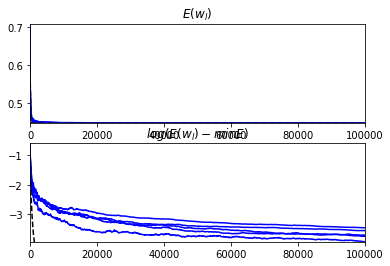

In [62]:
niter = 100000
nsamples = 5
err_rate = 50

ElistS = np.zeros( ( int(niter/err_rate), nsamples) )
for irun in np.arange(0,nsamples):
    w = np.zeros( (p+1,1) )
    for it in np.arange(0,niter):
        if np.mod(it,err_rate)==1:
            print(E(w,AddBias(X_train),y_train))
            ElistS[ int(it/err_rate),irun ] = E(w,AddBias(X_train),y_train)
        tau = tau0 / (1+it/l0)
        i = int( np.floor(np.random.rand()*n) )   # draw uniformly
        w = w - tau * nablaEi(w,i)


plt.subplot(2,1,1)
plt.plot( np.arange(0,niter,err_rate), ElistS, 'b')
plt.plot(1+np.arange(0,Elist.size)*n, Elist, 'k--')
plt.axis((1,niter, ElistS.flatten().min(), ElistS.flatten().max() ))
plt.title('$E(w_l)$')

vmin = np.min( (np.min(Elist), ElistS.flatten().min() ) )
u = np.log10(ElistS-vmin+1e-20)
v = np.log10(Elist -vmin+1e-20)
plt.subplot(2,1,2)
plt.plot( np.arange(0,niter,err_rate), u, 'b' )
plt.plot(1+np.arange(0,Elist.size)*n,  v, 'k--' )
plt.axis((1,niter, np.min(u), np.max(u) ))
plt.title('$log(E(w_l) - min E)$')

In [63]:
Theta = theta(AddBias(X_test).dot(w))

In [64]:
y_test_pred=np.apply_along_axis(return_class,1,Theta)
y_test_pred=np.array(y_test_pred).reshape(-1,1)

In [65]:
accuracy_score(y_test,y_test_pred)

0.7981927710843374

The accuracy score is close to 80% but still, lower than with the simple Gradient Descent. This can be explained by the size of the dataset which is here reasonable. SGD is not necessary.  

Let's compare our score with recoded gradient descent to sklearn Logistic Classifier score.

### Logistic classification with Sklearn 

In [66]:
modele=LogisticRegression(C=1e10)
modele.fit(X_train,y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=10000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [67]:
y_test_pred=modele.predict(X_test)

In [68]:
accuracy_score(y_test,y_test_pred)

0.8012048192771084

We find a result very close to the gradient descent we've coded!  
This final score is satisfying. We could still try to optimize it by testing other models, Support Vector Classifier for example.